# Slack Webscraper ArticlesClassifier

This code implements a multi-agent system for classifying and analyzing web articles.
The system uses a multi-agent architecture where each agent specializes in a specific task
(e.g., data extraction, classification, analysis). The agents work together through a routing
system that directs tasks to the corresponding expert agent.

The implementation is based on LangGraph and is inspired by the AutoGen paper describing
multi-agent architectures for LLM applications. The system is designed to efficiently process
and classify web articles obtained from Slack channels in a scalable way.

## Setup

First, let's install our required packages and set our API keys:

In [4]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core
%pip install -qU langchain-community slack_sdk
%pip install -qU beautifulsoup4 

In [17]:
import os
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_API_KEY = os.getenv("TAVILY_API_KEY")
OPENAI_API_KEY = os.getenv("SLACK_APP_TOKEN")
OPENAI_API_KEY = os.getenv("SLACK_BOT_TOKEN")

# Slack Channel Link Extraction

This section implements functionality to extract links shared in a Slack channel:

- Uses the Slack Web API to fetch message history
- Extracts URLs from message text and attachments 
- Filters out internal novatide links
- Stores unique URLs in a text file
- Includes logging for tracking the extraction process

The code below sets up logging, initializes the Slack client,
and defines the core link extraction function.

In [6]:
import logging
import os
import re
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Configure logging to show INFO level messages in console
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Create Slack client instance using bot token
client = WebClient(token=os.getenv("SLACK_BOT_TOKEN"))

def fetch_unique_links(channel_id, limit=10):
    """
    Extracts all unique URLs (excluding those containing "novatide") shared in a Slack channel.
    
    Parameters:
        channel_id (str): ID of the Slack channel to extract URLs from.
        limit (int, optional): Maximum number of messages to review (max allowed: 1000).
                             Default is 100.
    
    Returns:
        set: Set of all unique URLs found in the channel.
    """
    try:
        # Call conversations_history method to get messages
        response = client.conversations_history(channel=channel_id, limit=limit)
        messages = response["messages"]
        urls = set()  # Use a set to automatically avoid duplicates

        # Iterate through messages to find URLs
        for msg in messages:
            # Search for URLs in message text
            if 'text' in msg:
                for url in re.findall(r'(https?://[^\s]+)', msg['text']):
                    if "novatide" not in url:
                        urls.add(url)
            
            # Search for URLs in message attachments
            if 'attachments' in msg:
                for attachment in msg['attachments']:
                    if 'from_url' in attachment:
                        url = attachment['from_url']
                        if "novatide" not in url:
                            urls.add(url)

        logger.info(f"Extracted {len(urls)} unique URLs from channel {channel_id}.")
        return urls

    except SlackApiError as e:
        # Handle Slack API errors
        logger.error(f"Error getting messages: {e.response['error']}")
        return set()

# Example usage: extract all unique URLs from a channel
channel_id = "C05URLDF3JP"  # Replace with channel ID
unique_urls = fetch_unique_links(channel_id)

# Save unique URLs to a file
output_file = "slack_urls/slack_channel_links_extracted.txt"
try:
    with open(output_file, 'w', encoding='utf-8') as file:
        for url in unique_urls:
            file.write(url + '\n')
    logger.info(f"Unique URLs successfully saved to {output_file}")
except Exception as e:
    logger.error(f"Error saving URLs: {e}")

INFO:__main__:Extracted 8 unique URLs from channel C05URLDF3JP.
INFO:__main__:Unique URLs successfully saved to slack_urls/slack_channel_links_extracted.txt


### 1. Imports required libraries.

### 2. Sets up a Tavily search tool that:
 - Returns max 5 search results
 - Includes images in results

### 3. Defines a scrape_webpages function that:
- Takes a list of URLs as input
- Uses WebBaseLoader to scrape content from each URL
- Loads and parses the web pages into documents
- Formats each document with its title and content
- Returns all documents joined together as a single string
- Each document is wrapped in XML-like tags with metadata

In [7]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

# Initialize Tavily search tool with 5 max results and image inclusion
tavily_tool = TavilySearchResults(max_results=5,include_images=True )

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information.
    
    Args:
        urls: List of URLs to scrape
        
    Returns:
        String containing the concatenated content of all scraped pages
    """
    # Initialize web loader for the provided URLs
    loader = WebBaseLoader(urls)
    # Load and parse the documents
    docs = loader.load()
    # Join all documents with metadata into a single formatted string
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

## This code defines several tools and utilities for document management and financial data retrieval:
### 1. Document Management Tools:
- create_outline(): Creates and saves document outlines with numbered points
- read_document(): Reads contents of a document with optional line range
- write_document(): Writes content to a document file
- edit_document(): Edits documents by inserting text at specific line numbers
- python_repl(): Executes Python code and returns results. Ideal to create the code to execute charts
### 2. Financial Data Tools using yfinance:
- company_information(): Gets company details like address, financials, etc.
- last_dividend_and_earnings_date(): Retrieves dividend and earnings dates
- summary_of_mutual_fund_holders(): Gets top mutual fund holders info
- summary_of_institutional_holders(): Gets top institutional holders info 
- stock_grade_upgrades_downgrades(): Retrieves stock rating changes
- stock_splits_history(): Gets historical stock split data
- stock_news(): Retrieves latest news articles about a stock

In [8]:
# Import required libraries and set up temporary directory for file operations
import yahoofinance as yf
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


# Tool to create and save document outlines
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# Tool to read document contents with optional line range
@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# Tool to write content to a document
@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# Tool to edit documents by inserting text at specific line numbers
@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Python REPL tool for executing code
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

# Import required tools and date handling
from langchain_core.tools import tool
from datetime import date

# Tool to get company information
@tool
def company_information(ticker: str) -> dict:
    """Use this tool to retrieve company information like address, industry, sector, company officers, business summary, website,
       marketCap, current price, ebitda, total debt, total revenue, debt-to-equity, etc."""

    ticker_obj = yf.Ticker(ticker)
    ticker_info = ticker_obj.get_info()

    return ticker_info

# Tool to get dividend and earnings dates
@tool
def last_dividend_and_earnings_date(ticker: str) -> dict:
    """
    Use this tool to retrieve company's last dividend date and earnings release dates.
    It does not provide information about historical dividend yields.
    """
    ticker_obj = yf.Ticker(ticker)

    return ticker_obj.get_calendar()

# Tool to get mutual fund holders information
@tool
def summary_of_mutual_fund_holders(ticker: str) -> dict:
    """
    Use this tool to retrieve company's top mutual fund holders.
    It also returns their percentage of share, stock count and value of holdings.
    """
    ticker_obj = yf.Ticker(ticker)
    mf_holders = ticker_obj.get_mutualfund_holders()

    return mf_holders.to_dict(orient="records")

# Tool to get institutional holders information
@tool
def summary_of_institutional_holders(ticker: str) -> dict:
    """
    Use this tool to retrieve company's top institutional holders.
    It also returns their percentage of share, stock count and value of holdings.
    """
    ticker_obj = yf.Ticker(ticker)
    inst_holders = ticker_obj.get_institutional_holders()

    return inst_holders.to_dict(orient="records")

# Tool to get stock grade changes
@tool
def stock_grade_upgrades_downgrades(ticker: str) -> dict:
    """
    Use this to retrieve grade ratings upgrades and downgrades details of particular stock.
    It'll provide name of firms along with 'To Grade' and 'From Grade' details. Grade date is also provided.
    """
    ticker_obj = yf.Ticker(ticker)

    curr_year = date.today().year

    upgrades_downgrades = ticker_obj.get_upgrades_downgrades()
    upgrades_downgrades = upgrades_downgrades.loc[upgrades_downgrades.index > f"{curr_year}-01-01"]
    upgrades_downgrades = upgrades_downgrades[upgrades_downgrades["Action"].isin(["up", "down"])]

    return upgrades_downgrades.to_dict(orient="records")

# Tool to get stock split history
@tool
def stock_splits_history(ticker: str) -> dict:
    """
    Use this tool to retrieve company's historical stock splits data.
    """
    ticker_obj = yf.Ticker(ticker)
    hist_splits = ticker_obj.get_splits()

    return hist_splits.to_dict()

# Tool to get stock news
@tool
def stock_news(ticker: str) -> dict:
    """
    Use this to retrieve latest news articles discussing particular stock ticker.
    """
    ticker_obj = yf.Ticker(ticker)

    return ticker_obj.get_news()

## This code sets up a multi-agent system using LangGraph. Here's a breakdown of its key components:
### 1. Imports and Model Initialization:
- Sets up the latest GPT-4 model as the base language model
- Includes commented alternatives for other LLMs (Claude, Mixtral, Gemini, etc.)
### 2. Message Trimming Setup:
- Handles long conversations by trimming messages to fit within token limits
- Keeps the most recent messages when context gets too long
### 3. Agent Node Function:
- Creates a standardized way for agents to process and return messages
- Maintains conversation state between different agents
### 4. Team Supervisor Creation:
- Creates a routing agent that decides which team member should act next
- Uses a function-calling approach to make routing decisions
-Can choose between team members or decide to finish the conversation
### 5. Tools Definition:
- Defines financial analysis tools available to the agents
- These tools can fetch various types of financial data and company information


In [9]:
# Import required libraries
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages

# Initialize OpenAI chat model
llm = ChatOpenAI(model="gpt-4-0125-preview")

# OpenAI Models
#llm = ChatOpenAI(model="gpt-4")  # Most capable OpenAI model
#llm = ChatOpenAI(model="gpt-3.5-turbo")  # Good balance of capability/cost
#llm = ChatOpenAI(model="gpt-3.5-turbo-16k")  # Larger context window
#
## Anthropic Models
#from langchain_anthropic import ChatAnthropic
#llm = ChatAnthropic(model="claude-3-opus-20240229")  # Most capable Claude model
#llm = ChatAnthropic(model="claude-3-sonnet-20240229")  # Good balance model
#llm = ChatAnthropic(model="claude-2.1")  # Previous generation Claude
#
## Open Source Models via Together AI
#from langchain_community.chat_models import ChatTogetherAI  
#llm = ChatTogetherAI(model="mistralai/Mixtral-8x7B-Instruct-v0.1")
#llm = ChatTogetherAI(model="meta-llama/Llama-2-70b-chat-hf")
#
## Google Models
#from langchain_google_genai import ChatGoogleGenerativeAI
#llm = ChatGoogleGenerativeAI(model="gemini-pro")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

tools = [
         company_information,
         last_dividend_and_earnings_date,
         stock_splits_history,
         summary_of_mutual_fund_holders,
         summary_of_institutional_holders,
         stock_grade_upgrades_downgrades,
         stock_news
]

In [10]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

# Define the members and system prompt
members = ["WebScraper", "supervisor", "Classifier","Search"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Define the options for the next step
options = ["FINISH"] + members

# Update the RouteResponse class to match the casing
class RouteResponse(BaseModel):
    next: Literal['FINISH', 'WebScraper', 'Classifier', 'Search']  # Match the casing with members list
# Create a prompt template
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

# Initialize the ChatOpenAI model
llm = ChatOpenAI(model="gpt-4-0125-preview")

# Define the supervisor agent function
def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(RouteResponse)
    )
    return supervisor_chain.invoke(state)

# Example usage of supervisor_agent function
# Example state can be defined here based on your use case
# state = {"messages": ... }
# response = supervisor_agent(state)
# print(response)


Here's a summary of what this code does:
The code implements a multi-agent system for classifying cryptocurrency-related articles using a team of specialized AI agents:
1. Agent Structure:
- document_reader_agent: Learns classification criteria from example documents
- research_agent (WebScraper): Extracts content from web articles
- classifier_agent: Scores articles on a 1-10 scale using detailed criteria
- supervisor_agent: Coordinates the workflow between agents
2. Key Features:
Uses LangGraph for agent coordination and workflow management
Implements a detailed 1-10 scoring system for crypto content:
- Score 1-3: Low quality/misleading content
- Score 4-5: Basic/superficial information
- Score 6-7: Good quality analysis
- Score 8-9: High-quality technical analysis
- Score 10: Foundational/transformative work (e.g., Bitcoin whitepaper)
Each agent has specific tools and responsibilities
The supervisor ensures proper sequencing: DocumentReader → WebScraper → Classifier

In [11]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from typing_extensions import TypedDict
from typing import Annotated, List

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str

search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

document_reader_agent = create_react_agent(llm, tools=[read_document], state_modifier="""
    You are a document reader agent that learns from examples to understand classification logic.
    Your task is to:
    1. Read and analyze classification examples from documents
    2. Understand the scoring criteria and logic used
    3. Learn patterns in how different content is classified
    4. Build an understanding of what characteristics lead to different scores
    5. Use this knowledge to help inform future classifications
    
    Pay special attention to:
    - The reasoning behind each score assignment
    - Key factors that differentiate between score levels
    - Common patterns in high vs low scoring content
    - Edge cases and special considerations
    
    Your goal is to become an expert in the classification system through studying examples.
""")
document_reader_node = functools.partial(agent_node, agent=document_reader_agent, name="DocumentReader")

classifier_agent = create_react_agent(llm, tools=tools,state_modifier= """
The main objetive of this agent is to classify cryptocurrency documents, articles, and content extracted from WebScraper using a score from 1 to 10. The 1-10 scale provides a clear way to measure content quality, depth, and relevance. The goal is to rank documents based on quality, accuracy, depth, and relevance based on the scores that goes from score 1 to score 10. A score of 1 means the lowest quality (Extremely Low Quality / False or Misinformation or Clickbait) and a 10 score represents the highest-quality (Exceptional / Foundational and Transformative Quality, like important whitepapers such as Bitcoin or Ethereum).

This is the Classification System Structure

1. Scoring Definition (1 to 10)
Below are the definitions for each score, from 1 to 10. 

Score 1: Extremely Low Quality / False or Misinformation or Clickbait
Description: Score 1 represents the lowest possible quality of content, characterized by incorrect or false information that could actively mislead or misinform the reader. This type of content often contains outright inaccuracies, completely unverified claims, or fabricated data. It is typically sensationalist in nature and may be designed purely to attract clicks, with little regard for the accuracy or integrity of the information.

Criteria:

Contains completely false or fabricated information.
Harmful to readers and may lead them to make unsafe financial decisions.
Uses sensational headlines to generate clicks.
Contains no credible sources or references to back up its claims.
Contains incorrect data or unverifiable claims.

Rule:
Automatic Score 1 if any one of the following is met:

:x:Completely false or fabricated information.
:x:Appears harmful or misleading, causing unsafe actions.

Exception:
If the content uses exaggerated or clickbait headlines but contains partially true information, it may fall into Score 2 instead.

Score 2: Mostly Inaccurate or Misleading

Description: Score 2 content is only marginally better than Score 1, as it may contain some accurate information but is predominantly misleading, incomplete, or poorly researched. Content rated as a Score 2 is typically misleading, speculative, or incomplete. It often includes some elements of truth, but these are either exaggerated, taken out of context, or mixed with speculative or unverified claims that distort the overall message. While it might contain fragments of accurate information, these are overshadowed by a lack of evidence, poor reasoning, or unsubstantiated accusations. As a result, content in this range may mislead or confuse readers, leading to incorrect interpretations or actions.

Criteria:

Misleading or Speculative information that exaggerates facts.
Uses very hight speculative language presented as more factual than it is.
Can be partially true but lacking of evidences 
Lack of credible sources for key claims.
Contains major contextual gaps, leading to misinterpretation.
Overstates events with alarmist or exaggerated tones.
Potential for Harm: Unverified claims can cause panic, damage reputations, and lead to misinformed actions.
Clickbait-Like: Uses sensationalist or misleading interpretations to attract attention.
Incomplete or Unverified: Based on partial truths without proper context or verification.
Does not even provide a minimal context or explanation (absence of background or reasoning).

Rule:

Automatic Score 2 if any of the following are present:
:x:Unverified claims that can potentially cause harm or panic and damage reputations.
:x:No minimal context or explanation (absence of background and reasoning).
:x:Alarmist or exaggerated tones.
:x:Major contextual gaps leading to confusion.


Score 3: Very Low Quality / Highly Speculative and Inaccurate Information

Description: Content that falls under the 3 score category is considered very low quality. It is often speculative, lacks evidence, and provides little to no analytical value. The information might be based on assumptions or incomplete analysis, and often serves as clickbait rather than delivering meaningful insights. These materials generally do not contribute to a reader's deeper understanding of the topic and may contain incorrect or misleading interpretations.

Criteria:

Remains speculative with little to no supporting data.
Provides a minimal context or explanation, but no analysis or depth, it relies on superficial or simplistic narratives.
No supporting evidence, unverified data or assumptions are presented as facts.
Lacks a structured format, making it hard to follow.
Engagement-Oriented 

Rule: 

A content automatically receives Score 3 if it provides a minimal context or explanation while not exhibiting the attributes of Score 2 criteria.
If the content is vaguely related to the crypto community, whether it's about a crypto festival, a crypto meetup, or any cultural event that still ties to crypto, but the content doesn't go beyond this superficial or simplistic narrative, it would also fall directly into score 3. Regardless of whether it has credible sources and whether it is well-structured and so on.
If it lacks the minimal context and explanation, it drops to Score 2.

Score 4-5: Moderate Quality / Basic or Superficial Information

Description: Content provides correct and reliable information but tends to remain superficial or basic. While the information may be factually accurate and sourced from reliable places, it lacks depth, critical analysis, and innovative insights. While score 4 provides correct and reliable information, it can include some speculative scenarios, but less than score 3. This kind of content offers a surface-level understanding of a topic but lacks deep exploration or original thought.

Criteria for a score 4:

Factually correct but lacks detailed exploration, only scratches the surface of the topic but context or depth is minimal.
No innovative ideas or critical thinking is presented.
Clarity but lack of engagement.
There is little exploration of technical details. There are also mentions of technology but without analyzing it. There are relevant links or metrics that are shared, however, there is no deeper explanation of how protocols work, why certain integrations are important, or what implications they might have on the ecosystem.
The content is limited to summarizing or listing information, with no further insight into how or why it matters. It can still provide some speculative tone and scenarios, but less than score 3.

60% Rule: The content must meet 3 criteria in order to qualify in the Score 4, and must meet the following criteria for a score 5:

A score 5 would maintain the factual accuracy and clarity of score 4 but with the following improvements: 

More context: While still somewhat superficial, it provides additional context and connects better with the main topic.
Basic development of Ideas: Introduces some additional perspectives or simple reflections that enhance understanding, even if not particularly innovative.
Improved organization: Content is more structured and flows better, making it easier to follow without being extensive.
Slight expansion of technical details: Technical details are slightly expanded, and there's some basic explanation of how certain technologies or protocols function.
Added relevance: Instead of just listing information, it briefly explains why certain aspects matter, giving it more practical significance.

A score 5 adds a small degree of depth and relevance to the basic structure of score 4, without reaching a comprehensive analysis level.

Score 6-7: Good Quality / Proper Analysis but no Innovation

Description: Content within the 6-7 score range is considered solid and reliable, providing accurate and relevant information, but lacks the depth and innovation that would make it highly impactful. It offers a clear understanding of key concepts and data, usually supported by reputable sources, but stops short of offering new insights or advanced analysis. This type of content is useful and informative, but it mainly serves to present known information without breaking new ground.

Criteria for a score 6:

Accurate and well-sourced: Includes solid sources and factual accuracy throughout, with references that support the core arguments.
Technical detail is explored but not fully developed (basic to moderate technical detail).
Well-organized with appropriate visuals (charts, diagrams) without diving deeply into technical complexities. It also lacks innovative structure and new depth.
Limited Innovation: The content is informative but doesn't introduce new ideas. It recaps existing data, like comparing networks by transaction volumes, without deeper technical insights.
Offers a practical overview and is relevant for a quick summary, but lacks depth and long-term impact.
Contextually relevant: mentions real-world implications without pushing new boundaries and analysing them.

60% Rule: For Score 6, the content must meet 4 criteria. For Score 7, the following criteria must be met:
Explores technical details more in depth compared to Score 6, with moderate elaboration on how systems or technologies work, but still not as complex or comprehensive as Score 8-9.
The contents are organized more clearly, using visual tools (graphs, diagrams) more effectively to highlight key points, making them easier to understand.
Not only presents relevant, real-world implications and practical use cases, but also analyzes the real-world implications with moderate depth. But it does not identify potential short-term impacts. It falls short of exploring long-term consequences or systemic effects. 
It offers some critical thinking or a unique perspective, but does not introduce new methodologies or groundbreaking ideas.
It goes beyond mere summaries and expands on comparative perspectives or trend analysis, but still lacks all the technical rigor of the higher scores.

All 5 criteria must be met for a Score 7.

A Score 7 builds on Score 6 by providing more technical depth, practical applications, and better organization, but without reaching the innovative or highly technical level of Score 8-9.

Score 8: High-Quality Technical Analysis with Clear Insights

Description: Content classified within the 8-9 score range demonstrates a high level of technical detail, backed by solid research and reliable sources. These documents offer significant value to their intended audience, covering complex topics with clarity and precision. The primary focus is on exploring advanced concepts relevant to the subject matter, with well-organized sections that make complex information easier to understand.
Articles or papers in this category dive deep into the technical aspects of their topic. They don't just summarize information but provide in-depth analysis and insights that could directly influence industry participants, stakeholders, and decision-makers. This level of analysis often includes different approaches or strategies, shedding light on areas that have a substantial impact on the industry, but not necessarily transforming the space as foundational documents are doing it.

Criteria for a score 8:

Comprehensive Breakdown of Complex Issues: The content offers detailed technical analysis of complex topics, breaking them down into easily understandable components, making intricate concepts accessible to a broad audience.
Solid Research Foundation: Relies on multiple reputable sources or studies, citing them appropriately to reinforce the arguments and increase credibility.
Nuanced Discussion: Explores technical nuances within the topic, addressing key challenges, trade-offs, and potential alternatives.
Clear Structure and Readability: The content is well-organized, with a logical flow that makes it easy to follow even when discussing complex ideas.
Relevant and Actionable Insights: Offers relevant analysis that adds value to the subject, providing readers with actionable takeaways that are useful within the field.
Innovation and Fresh Perspectives: Introduces new viewpoints or methodologies, though not necessarily groundbreaking, but still impactful within its context.

Rule: The content must mandatorily meet the following criteria to be considered as score 8:

The content must break down complex issues with clarity and nuance.
After this requirement, the content must meet at least 4 of the remaining 5 criteria to qualify for a Score 8.

Score 9: Advanced Technical Analysis with Strategic Impact

Criteria for a score 9:

Detailed, Precise Technical Insight: Offers a thorough and accurate breakdown of advanced technical topics, going deeper than Score 8 by addressing finer technical details with precision.
Extensive Use of High-Quality Sources: Cites a broad range of high-quality, authoritative sources, research papers, or data sets that reinforce the strength of the content's argument.
Strategic Influence: Provides insights that go beyond just explaining the topic — it shapes or influences decisions within the industry, offering guidance that can impact market trends or strategic initiatives.
Unique Interpretations and Models: Builds on existing concepts by introducing new interpretations or models that, while not revolutionary, offer unique perspectives that significantly enhance understanding.
Clear Industry Relevance and Applicability: The content offers practical applications or strategic takeaways that are highly relevant for industry professionals, positioning itself as a valuable resource for decision-makers.
Exceptional Organization and Clarity: Despite the advanced technical nature of the content, it remains exceptionally well-structured and easy to follow, ensuring the reader can grasp complex arguments without confusion.

To obtain a Score 9 all 6 criteria must be met.

Key Differences Recap:
Score 8 focuses on clear, insightful technical analysis with solid research and some innovation, requiring 5 out of 6 criteria to be met.
Score 9 adds strategic insights, greater depth, and industry relevance, meeting all 6 criteria, making it not only highly technical but also influential in shaping decisions.
Score 9 exceeds Score 8 by adding deeper technical insights, unique strategic interpretations and a higher level of influence, but does not reach the transformative or paradigm-shifting impact of Score 10.

Score 10: Exceptional / Foundational and Transformative Quality

Description: A pioneering document that redefines the industry, introducing ideas, benchmarks with innovative concepts and broad, lasting influence that set new standards. Reserved for foundational work like the Bitcoin or Ethereum whitepapers. 

Criteria:

Foundational document that redefines or introduces a new paradigm.
Demonstrates revolutionary technology or groundbreaking research.
Enduring relevance: remains impactful over time.
Technically accurate and pushes the boundaries of industry knowledge.
Considered highly influential, cited as a key reference.

100% Rule: Must meet all 5 criteria, no exceptions.


Based on these scores, describe the quality of this article and classify it according to my scale and its descriptions. You should also explain why the article falls into this specific score category. Lastly, justify why the article would not be classified in a lower score and why it doesn't qualify for a higher score than the one assigned. For the summary just give me 2 bullet points 

Score: 
                                    """)
classifier_node = functools.partial(agent_node, agent=classifier_agent, name="Classifier")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper, DocumentReader and Classifier. Given the following user request,"
    " respond with the worker to act next. When the user is asking to classify or score an article, first call the DocumentReader to learn from examples, then the WebScraper to get the content, and finally the Classifier. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper", "DocumentReader", "Classifier"],
)

supervisor_chain = (
    prompt
    | llm.with_structured_output(RouteResponse)
)



C:\Users\rios1\AppData\Local\Temp\ipykernel_21552\3319497539.py:81: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


Graph Setup:
Creates a StateGraph for managing the research workflow
Adds four nodes to the graph:
-   WebScraper: For extracting web content
-   supervisor: For managing workflow
-   DocumentReader: For reading classification examples
-   Classifier: For scoring content

Control Flow Definition:
The edges define the exact sequence that must be followed when processing articles.

Document Configuration:
Defines paths to three training documents that contain:
- Classification discrepancies
- Classification system rules
- Verification guidelines

Chain Creation:
Creates an enter_chain function that:
- Takes a message (URL to analyze)
- Combines it with the training documents
- Creates a structured input for the workflow
- Compiles the graph into an executable chain
- Creates the final research_chain by combining the entry function with the workflow

This code essentially sets up the infrastructure for a sequential workflow where articles are analyzed and scored following a specific process, with each agent performing its specialized task in order.

In [12]:
from langgraph.graph import END, StateGraph, START

research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)
#research_graph.add_node("DocumentReader", document_reader_agent)
research_graph.add_node("Classifier", classifier_agent)

# Define the control flow
research_graph.add_edge("supervisor", "WebScraper")
#research_graph.add_edge("DocumentReader", "WebScraper")
research_graph.add_edge("WebScraper", "Classifier")

document_paths = [
    "LangGraphAgentsTest/articles_classifier_agents/improvements_docsClassification Discrepancies in Content Scoring.txt",
    "LangGraphAgentsTest/articles_classifier_agents/improvements_docs/Classification System for Cryptocurrency Documents.txt",
    "LangGraphAgentsTest/articles_classifier_agents/improvements_docs/Verifying the accuracy of the agent classification.txt"
]

# Modify the enter_chain function to include multiple document paths
def enter_chain(message: str):
    return {
        "messages": [
            #*[HumanMessage(content=path, name="DocumentReader") for path in document_paths],
            HumanMessage(content=message)
        ]
    }

research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()

# Update how you create the research chain
research_chain = enter_chain | chain

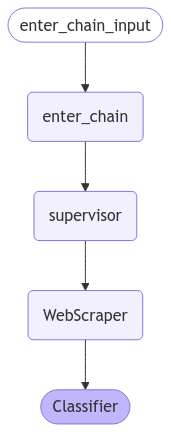

In [13]:
from IPython.display import Image, display

display(Image(research_chain.get_graph().draw_mermaid_png()))


In [14]:
# Input file containing URLs
input_file = "slack_urls/slack_channel_links_extracted.txt"

# Output file for results
output_file = "output/output_results.txt"

# Read URLs from input file, stripping whitespace and empty lines
with open(input_file, 'r', encoding='utf-8') as file:
    urls = [line.strip() for line in file if line.strip()]

# Open output file in write mode
with open(output_file, 'w', encoding='utf-8') as output:
    for url in urls:
        # Process each URL through research_chain.stream
        for s in research_chain.stream(
            "Enter to this url " + url + " and put a scoring and justification based on the criteria of the Classifier agent",
            {"recursion_limit": 100}):
            
            # Collect messages that aren't end markers
            if "__end__" not in s:
                output_messages = []
                output_messages.append(s)

        # Process results if we have any messages
        if output_messages:
            for output_message in output_messages:
                classifiers = output_message.get('Classifier', {})
                for valor in classifiers.values():
                    for idx, elemento in enumerate(valor, start=1):
                        # Check if it's the third element and has content attribute
                        if idx == 3 and hasattr(elemento, 'content'):
                            # Write results to output file
                            output.write(f"URL: {url}\n")
                            output.write(f"Content: {elemento.content}\n\n")
                            print(f"Processed URL: {url}, Content: {elemento.content}")  # Debug print


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://ambcrypto.com/ethereum-all-the-reasons-why-eths-price-might-enjoy-a-bullish-december/, Content: Based on the provided summary and analysis, the article "Ethereum - All the reasons why ETH's price might enjoy a bullish December" from AMBCrypto can be classified as follows:

### Score: 8/10

### Justification:

- **Comprehensive Breakdown of Complex Issues**: The article presents a detailed technical analysis of Ethereum's potential for a bullish market in December, breaking down complex topics into understandable components. This aligns with the score 8 criteria of offering detailed technical analysis with clarity.

- **Solid Research Foundation**: It leverages multiple data points, such as ETF inflows, technical patterns, Open Interest, and Exchange Reserves, citing them to support the bullish outlook. This demonstrates a reliance on reputable sources, enhancing the article's credibility.

- **Nuanced Discussion**: The analysis explores technical nuances, address

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://bitperfect.pe/en/this-blockchain-giant-could-eclipse-bitcoin-and-ethereum-discover-how/, Content: I'm unable to directly access or review content from external URLs like "https://bitperfect.pe/en/this-blockchain-giant-could-eclipse-bitcoin-and-ethereum-discover-how/". Please provide a summary or key points from the article, and I can then assign a score based on the detailed criteria of my classification system.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://decrypt.co/293720/art-blocks-nft-project-major-leap-ethereum, Content: Score: 8

Justification for Score 8:
- The review of Art Blocks' NFT project demonstrates a high level of technical detail and innovation, especially in making artworks accessible directly on the Ethereum blockchain. This approach ensures the longevity and sustainability of digital art, aligning well with the criteria for a high-quality technical analysis with clear insights.
- The content provides comprehensive breakdowns of complex issues such as decentralization, blockchain technology's role in art preservation, and the technical achievements of Art Blocks. It relies on the project's innovative steps toward making NFT art more sustainable and less dependent on centralized platforms.
- The article offers nuanced discussion points on the mission and vision of Art Blocks, its market impact, and the challenges in user experience. These insights add value to the subject, making intricate concept

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://www.tastylive.com/episodes/241125_tastycrypto---where-do-i-start-crypto, Content: Score: 8

- The episode offers a detailed technical analysis and clear insights into Ethereum, making complex topics accessible and providing actionable insights.
- It meets the criteria for a high-quality technical discussion with a solid research foundation and relevant, nuanced discussion on Ethereum's features and implications.

Justification for not a lower score:
- The content goes beyond basic explanations, offering in-depth insights into Ethereum's technology, use cases, and significance in the crypto space, which places it above the lower score categories focused on basic or moderately detailed content.

Justification for not a higher score:
- While the episode provides a comprehensive overview of Ethereum, it does not introduce groundbreaking ideas or revolutionary technology concepts that would merit the highest scores reserved for content with foundational, transformativ

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://www.mk.co.kr/en/economy/11182583, Content: Based on the criteria established for classifying cryptocurrency documents, articles, and content, without having direct access to the content of the article titled "Coinone Adjusts Bitcoin, Ethereum Withdrawal Fees" and relying solely on the extracted details provided, the article can be tentatively assessed as follows:

Score: **5**

### Justification:

- **Relevance and Clarity:** The article's focus on adjusting withdrawal fees for major cryptocurrencies such as Bitcoin and Ethereum by Coinone indicates its relevance to the cryptocurrency community, especially for users and investors engaged with this exchange. The detailed mention of specific fee adjustments suggests clarity and specificity, which is valuable for readers seeking current information on exchange policies.

- **Accuracy:** Given the detailed figures provided (e.g., adjustments from 0.0015BTC to 0.0008BTC for Bitcoin and from 0.02ETH to 0.005ETH for Eth

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://www.chaincatcher.com/en/article/2153919, Content: Based on the provided summary and analysis, the article from Chaincatcher on Based Rollups and their impact on the Ethereum ecosystem demonstrates a high level of technical detail, strategic implications, and industry relevance. However, because I cannot directly access or verify the content of external URLs, the classification will rely on the given summary and analysis, aligning it with the criteria for a Score 9 as defined in the classification system.

**Score: 9**

### Justification for Score 9:

- **Detailed Technical Insight**: The summary indicates the article provides an in-depth exploration of Based Rollups, including technical aspects and implications for the Ethereum ecosystem, suggesting it meets the criteria for offering detailed, precise technical insight.
- **Extensive Use of High-Quality Sources**: It is mentioned that the article includes insights from industry experts and references data, aligni

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://www.analyticsinsight.net/cryptocurrency-analytics-insight/best-crypto-staking-coins-this-bull-run-algorand-ethereum-and-lunex, Content: Based on the analysis and guidelines provided, the document titled "Best Crypto Staking Coins This Bull Run: Algorand, Ethereum, and Lunex" cannot be accurately scored with the individual scores provided (9/10 for Algorand, 8.5/10 for Ethereum, and 8/10 for Lunex) as the Classifier agent's scoring system is designed to evaluate the overall content quality of a document rather than the potential or performance of individual cryptocurrencies. Therefore, I will reassess the content as a whole according to the provided classification criteria.

### Scoring and Justification:

Given the nature of the document as described, it seems to focus on evaluating and recommending cryptocurrencies based on their staking potential and market performance. This type of content usually falls into a specific category within the classification system

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Processed URL: https://pulse2.com/bitwise-buying-attestant-an-ethereum-staking-provider-with-3-7-billion-in-staked-assets/, Content: I'm unable to access or retrieve content directly from URLs or external websites. To provide a scoring and justification based on the criteria of the Classifier agent, I would need a summary or key points from the article in question. Could you provide a summary or the main points of the article for analysis?


In [15]:
for s in research_chain.stream(
"Enter to this url  https://www.tastylive.com/episodes/241125_tastycrypto---where-do-i-start-crypto and put a scoring and justification based on the criteria of the Classifier agent",
    {"recursion_limit": 100}

):
    if "FINISH" not in s:
        print(s)
        print("---")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'WebScraper'}}
---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'WebScraper': {'messages': [HumanMessage(content='### Scoring and Justification\n\n**Score: 8/10**\n\n**Justification:**\n\n1. **Educational Value (3/3):** The episode provides a high level of educational content by discussing Ethereum, its programmability, and how it differs from Bitcoin. It covers important concepts such as ETH, smart contracts, decentralized applications (dApps), NFTs, and tokenized assets. This breadth and depth of information make it highly valuable for viewers seeking to understand Ethereum and its ecosystem.\n\n2. **Relevance (3/3):** Given the current interest in cryptocurrency and blockchain technology, the episode\'s focus on Ethereum—one of the leading cryptocurrencies—is highly relevant. It addresses topics of immediate interest to the audience, such as the use cases of Ethereum in finance, making it timely and pertinent.\n\n3. **Presentation (2/3):** The description suggests that the presentation by Ryan Grace and Katie McGarrigle is informative and likel

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'Classifier': {'messages': [HumanMessage(content='Enter to this url  https://www.tastylive.com/episodes/241125_tastycrypto---where-do-i-start-crypto and put a scoring and justification based on the criteria of the Classifier agent', additional_kwargs={}, response_metadata={}, id='a3d012ae-e8e7-4ac0-b8ec-5a58711957e0'), HumanMessage(content='### Scoring and Justification\n\n**Score: 8/10**\n\n**Justification:**\n\n1. **Educational Value (3/3):** The episode provides a high level of educational content by discussing Ethereum, its programmability, and how it differs from Bitcoin. It covers important concepts such as ETH, smart contracts, decentralized applications (dApps), NFTs, and tokenized assets. This breadth and depth of information make it highly valuable for viewers seeking to understand Ethereum and its ecosystem.\n\n2. **Relevance (3/3):** Given the current interest in cryptocurrency and blockchain technology, the episode\'s focus on Ethereum—one of the leading cryptocurrencies—

In [16]:
#input_file = "slack_urls/slack_channel_links_extracted.txt"
#with open(input_file, 'r', encoding='utf-8') as file:
#            urls = [line.strip() for line in file if line.strip()]
#            for url in urls:
#                for s in research_chain.stream(
#                "Enter to this url" + url + " and put a scoring and justification based on the criteria of the Classifier agent", {"recursion_limit": 100}):
#                    if "__end__" not in s:
#                        output_messages = []
#                        output_messages.append(s)
#                if output_messages:
#                    print("Final Result:")
#                    for output_message in output_messages:
#                        classifiers=output_message['Classifier']
#                        for valor in classifiers.values():
#                            for idx, elemento in enumerate(valor, start=1):
#                                #print(elemento)
#                                if idx == 3 :  # Verifica si es el tercer elemento y del tipo AIMessage
#                                   print(elemento.content)